In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import seaborn as sn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from modAL.models import ActiveLearner
import scipy.integrate as sci
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic, Matern
from modAL.models import ActiveLearner
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.stats import norm
from scipy.special import ndtr
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import warnings
from time import perf_counter
from mpl_toolkits.mplot3d import Axes3D
from tkinter import *     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename
%matplotlib inline

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load physics model data

In [2]:
def create_grid(LB, UB, num, dim, num_diff):
    if num_diff == 1:
        if dim == 2:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[0], UB[0], num)
        elif dim == 3:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[0], UB[0], num)
            w = np.linspace(LB[0], UB[0], num)
        else:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[0], UB[0], num)
            w = np.linspace(LB[0], UB[0], num)
            v = np.linspace(LB[0], UB[0], num)
    elif num_diff == 2:
        if dim == 2:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[1], UB[1], num)
        elif dim == 3:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[0], UB[0], num)
            w = np.linspace(LB[1], UB[1], num)
        else:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[0], UB[0], num)
            w = np.linspace(LB[1], UB[1], num)
            v = np.linspace(LB[1], UB[1], num)
    else:
        if dim == 3:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[1], UB[1], num)
            w = np.linspace(LB[2], UB[2], num)
        else:
            x = np.linspace(LB[0], UB[0], num)
            y = np.linspace(LB[1], UB[1], num)
            w = np.linspace(LB[2], UB[2], num)
            v = np.linspace(LB[3], UB[3], num)
    if dim == 2:
        z = np.meshgrid(x, y, indexing='ij')
        z_ = np.zeros((num**dim,dim))
        for row in range(num**dim):
            z_[row] = [np.ravel(z[0])[row], np.ravel(z[1])[row]]
    elif dim == 3:
        z = np.meshgrid(x, y, w, indexing='ij')
        z_ = np.zeros((num**dim,dim))
        for row in range(num**dim):
            z_[row] = [np.ravel(z[0])[row], np.ravel(z[1])[row], np.ravel(z[2])[row]]
    elif dim == 4:
        z = np.meshgrid(x, y, w, v, indexing='ij')
        z_ = np.zeros((num**dim,dim))
        for row in range(num**dim):
            z_[row] = [np.ravel(z[0])[row], np.ravel(z[1])[row], np.ravel(z[2])[row], np.ravel(z[3])[row]]
    elif dim == 6:
        z = np.meshgrid(x, x, x, x, x, x, indexing='ij')
        z_ = np.zeros((num**dim,dim))
        for row in range(num**dim):
            z_[row] = [np.ravel(z[0])[row], np.ravel(z[1])[row], np.ravel(z[2])[row], np.ravel(z[3])[row], np.ravel(z[4])[row], np.ravel(z[5])[row]]

    return z_

In [3]:
def get_obj_info(obj_name, info_name):
    obj_fun_info = pd.read_csv('obj_test.csv', sep=',', header=0)
    obj_fun_info = obj_fun_info.values
    
    obj_row = obj_fun_info[obj_fun_info[:,0] == obj_name,:]
    
    if info_name == 'dims':
        return int(obj_row[0,1])
    elif info_name == 'params':
        params = obj_row[0,2].split()
        ind = 0
        for par in params:
            params[ind] = float(par)
            ind += 1
        return params
    elif info_name == 'param var':
        variance = obj_row[0,3].split()
        ind = 0
        for var in variance:
            variance[ind] = float(var)
            ind += 1
        return variance
    elif info_name == 'num params':
        return int(obj_row[0,4])
    elif info_name == 'LB':
        LB = obj_row[0,5].split()
        ind=0
        for L in LB:
            LB[ind] = float(L)
            ind += 1
        return LB
    elif info_name == 'UB':
        UB = obj_row[0,6].split()
        ind=0
        for U in UB:
            UB[ind] = float(U)
            ind += 1
        return UB

In [5]:
ob_name = 'CO2_pulse_3'

dims = 3
num = 10
LB = get_obj_info(ob_name, 'LB')
UB = get_obj_info(ob_name, 'UB')
X = create_grid(LB, UB, num, dims, 3)
X_tot = X
first_V = X_tot[range(0,num**dims, num),:2]
# print(np.linspace(10,1500, num=40))
# print(np.linspace(3,4,num=40))

X_tot_num = np.append(X_tot, np.zeros((len(X_tot),1)), axis=1)
for j in range(len(X_tot_num)):
    X_tot_num[j,3] = j
print(X_tot_num)

# with plt.style.context('seaborn-white'):
#     plt.figure(figsize=(8, 8))
#     plt.scatter(data_tot[:, 0], data_tot[:, 1], c=np.ravel(data_tot[:,2]), s = 50, cmap='viridis')
#     plt.colorbar()
#     plt.scatter(top_data[0], top_data[1], c='k', s=200)
#     plt.title('Physics Model')

[[1.00000000e+01 1.00000000e+01 1.00000000e+02 0.00000000e+00]
 [1.00000000e+01 1.00000000e+01 1.22222222e+02 1.00000000e+00]
 [1.00000000e+01 1.00000000e+01 1.44444444e+02 2.00000000e+00]
 ...
 [1.50000000e+03 1.50000000e+03 2.55555556e+02 9.97000000e+02]
 [1.50000000e+03 1.50000000e+03 2.77777778e+02 9.98000000e+02]
 [1.50000000e+03 1.50000000e+03 3.00000000e+02 9.99000000e+02]]


In [6]:
## get_init function
def get_init_known(ob_name, init, dim, seed):

    choices = np.zeros((int(init),dim))
    y_choices = np.zeros((int(init),1))
    np.random.seed(seed)
    
    LB = get_obj_info(ob_name, 'LB')
    UB = get_obj_info(ob_name, 'UB')
    for col in range(dim):
        choices[:,col] = np.random.uniform(LB[col], UB[col], (int(init)))

    choices[:,:2] = np.floor(choices[:,:2])
    X_known = choices
    
    return X_known

## Select/input Initial experiments

If this is the first time running this, you will need to randomly select the initial experiments. In this case, **use the first 2 lines of code in the section below**, and comment out the rest. You will need to provide the number of initial experiments that are desired in the *get_init_known()* function.

If you already have initial experiments selected, comment out the first 2 lines of code and run the remaining part of the cell. It will ask you to input a file that contains the **X** values of the initial experiments that have already been selected. Make sure you input only the values of the initial experiments. So if you originally started with 10 initial experiments, make sure you select the file that includes only those 10 initial experiments. After choosing the file, **you need to close the small window for the code to continue running.**

A graph showing the locations of the initial experiments (in 2 dimensions) will display, and a list of the initial experiments will be displayed.

In [18]:
init_num = 10
# X_init = get_init_known(ob_name, init_num, dims, np.random.randint(1000))
# # ob_name, init, dim, seed, params
# X_init = X_init

# Use code below if already have initial points

root=Tk()
mylabel = Label(root, text='Choose file with initial data points.')
mylabel.pack()
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
mainloop()

X_init = pd.read_csv(filename, sep=',', header=None)
X_init = X_init.values

# X_init_ind = []
# for exper in X_init:
#     ind_coup = np.argwhere(X_tot == exper)
#     X_tot_ind = [ind_coup[row,0] for row in range(0,np.size(ind_coup[:,0])-1) if np.isin(ind_coup[row,0], ind_coup[row+1:, 0])]
#     X_init_ind = np.append(X_init_ind, X_tot_ind) 


# X_pool = np.delete(X_tot[:,:], X_init_ind.astype(int), axis=0)

print(X_init)

# with plt.style.context('seaborn-white'):
#     plt.figure(figsize=(8, 8))
#     plt.scatter(X_pool[:, 0], X_pool[:, 1], c='b', s = 200)
#     plt.scatter(X_init[:, 0], X_init[:, 1], c='r', s = 200)
#     plt.title('Initial Values', fontsize=20)
#     plt.xlabel('$t_{on}$', fontsize=20)
#     plt.ylabel('$t_{off}$', fontsize=20)

FileNotFoundError: [Errno 2] File  does not exist: ''

## Save initial experiments

If you just generated the initial experiments, you can save them as a file below. If you already have a file containing initial experiments, keep the cell below commented out.

Save initial experiments

In [35]:
# np.savetxt('CO2_pulse_4D_07-18-2021.csv', X_init, delimiter=',')

In [7]:
def max_score_ours(X_0, X_known, y_known, X_grid, regressor, params, LB, UB):
    beta = params
    
    X_0 = np.reshape(X_0, (1,-1))
    UB_arr = np.nonzero(X_0 > UB)
    UB_arr = np.asarray(UB_arr)
    LB_arr = np.nonzero(X_0 < LB)
    LB_arr = np.asarray(LB_arr)
    if UB_arr.size == 0 and LB_arr.size == 0:
        X_0
    elif UB_arr.size != 0:
        X_0[0][UB_arr[1]] = (UB+LB)/2
        if LB_arr.size != 0:
            X_0[0][LB_arr[1]] = (UB+LB)/2
    elif LB_arr.size != 0:
        X_0[0][LB_arr[1]] = (UB+LB)/2
        if UB_arr.size != 0:
            X_0[0][UB_arr[1]] = (UB+LB)/2
    
    check_nan = np.isnan(X_0)
    if sum(check_nan[0]) != 0:
        X_0[check_nan] = (UB+LB)/2
        
    test_pred, std = regressor.predict(X_0, return_std=True)
    test_pred = np.reshape(test_pred, (-1,1))
    
    grid_pred, grid_std = regressor.predict(X_grid, return_std=True)
    grid_pred = np.reshape(grid_pred, (-1,1))
    
    distance_scores = pairwise_distances(X_0, X_known, metric='euclidean')
    distance_scores = np.reshape(distance_scores, (1, len(X_known)))
    c = np.amin(distance_scores)
    
    max_grid_val = np.amax(X_grid)
    min_grid_val = np.amin(X_grid)
    dist_max = 0.5*(max_grid_val - min_grid_val)
    
    FE = 0
    STD = 0
    DIST = 0
    fe_max = np.amax(grid_pred)
    fe_min = np.amin(grid_pred)
    if fe_max == fe_min:
        fe_min = np.amin(y_known)
        fe_max = np.amax(y_known)
    FE = (test_pred - fe_min)/(fe_max-fe_min)
    STD = std
    DIST = (c)/(dist_max)
    if DIST < 0:
        DIST = 0
    similarity_score = 1 / (1 + DIST)
    score = beta*(1 - similarity_score) + beta*(STD) + (FE)
    score = np.ravel(score)
    return -score

In [10]:
## acquisition function definitions (daniel_query, PI, EI, UCB, Phoenics)
class acquisition():
    def __init__(self):
        self.descr = 'This is an acquisition function'
        
    ## get_acq_fun()
    def get_acq_fun(self, regressor,choice, X_grid, X_known, y_known, n_instances, params, LB, UB):
        if choice == 'ours':
            return self.ours(regressor, X_grid, X_known, y_known, n_instances, params, LB, UB)
        elif choice == 'PI':
            return self.PI(regressor, X_grid, X_known, y_known, n_instances, params, LB, UB)
        elif choice == 'EI':
            return self.EI(regressor, X_grid, X_known, y_known, n_instances, params, LB, UB)
        elif choice == 'UCB':
            return self.UCB(regressor, X_grid, X_known, y_known, n_instances, params, LB, UB)
        else:
            return 'Invalid input'
        
    def ours(self, regressor, X_grid, X_known, y_known, n_instances, params, LB, UB):
        # acq, X_pool, X_known, y_known, query_number, params, ob_name
        
        # Create an array where we're going to put the chosen X, X_new
        dims = X_known.shape[1]
        beta = params
        X_new = np.empty((0,dims))
        bnds = Bounds(LB, UB, keep_feasible=True)

        for j in range(0, n_instances):
            
            best_options = np.zeros((25,dims))
            best_scores = np.zeros((25,1))
            for k in range(0,25):
                x0 = np.zeros((dims))
                for col in range(dims):
                    x0[col] = np.random.uniform(LB[col]+0.001, UB[col]-0.001)
                res = minimize(max_score_ours, x0, args= (X_known, y_known, X_grid, regressor, params, LB, UB), method='L-BFGS-B',bounds = bnds)
        #             lsq = least_squares(max_score_ours, x0, args = (X_known, y_known, X_grid, regressor, params), bounds =(LB,UB))
                best_options[k] = res.x
                best_scores[k] = res.fun
            
            if j == 0:
                best_ind = np.argmin(best_scores)
                X_new = best_options[best_ind,:]
                X_new = np.reshape(X_new, (-1,dims))
            else:
                best_ind = np.argmin(best_scores)
                X_new_ = best_options[best_ind,:]
                X_new = np.append(X_new, X_new_)
                X_new = np.reshape(X_new, (-1,dims))
            
            X_known = np.append(X_known, X_new[j])
            X_known = np.reshape(X_known, (-1,dims))
            X_new_now = np.reshape(X_new[j], (1,-1))
            y_fake_new = regressor.predict(X_new_now)
            y_fake_new = np.reshape(y_fake_new, (-1,1))
            y_known = np.append(y_known, y_fake_new)
            y_known = np.reshape(y_known, (-1,1))
            regressor.fit(X_known, y_known)

        return X_new, dims

    def PI(self, regressor, X_grid, X_known, y_known, n_instances, params, LB, UB):
        # self, regressor, X_grid, X_known, y_known, n_instances, params, LB, UB
        # Create an array where we're going to put the chosen X, X_new
        dims = X_known.shape[1]
        tradeoff = params[3]
        X_new = np.empty((0,dims))
        for j in range(0, n_instances):
            
            x0 = np.zeros((dims))
            for col in range(dims):
                x0[col] = np.random.uniform(LB[col]+0.001, UB[col]-0.001)
            lsq = least_squares(max_score_PI, x0, args = (X_known, y_known, X_grid, regressor, params), bounds =(LB,UB))
            if j == 0:
                X_new = lsq.x
                X_new = np.reshape(X_new, (-1,dims))
            else:
                X_new = np.append(X_new, lsq.x)
                X_new = np.reshape(X_new, (-1,dims))
            
            X_known = np.append(X_known, X_new[j])
            X_known = np.reshape(X_known, (-1,dims))
            X_new_now = np.reshape(X_new[j], (1,-1))
            y_fake_new = regressor.predict(X_new_now)
            y_fake_new = np.reshape(y_fake_new, (-1,1))
            y_known = np.append(y_known, y_fake_new)
            y_known = np.reshape(y_known, (-1,1))

        return X_new, dims
    
    def EI(self, regressor, X_grid, X_known, y_known, n_instances, params):
        # Create an array where we're going to put the chosen X, X_new
        dims = X_known.shape[1]
        tradeoff = params[3]
        X_new = np.empty((0,dims))
        query_idx = np.zeros((n_instances,1), dtype=np.int32)
        for j in range(0, n_instances):
            if j == 0:
                lksjdfkljsd=0
            else:
                regressor.fit(X_known, y_known)
            # Predict the FE for the test values
            test_preds, std = regressor.predict(X_pool, return_std=True)
            test_preds = np.reshape(test_preds, (-1,1))
            std = np.reshape(std, (-1,1))
            test_max = np.amax(test_preds)
            scores = np.zeros(len(X_pool))
#             for k in range(0, len(X_pool)):
                # Need FE, std, and dist for each pool point
            z = ndtr((test_preds - test_max - tradeoff)/std)
            scores = (test_preds - test_max - tradeoff)*z + std*norm.pdf(z)
                
            query_idx[j] = np.argmax(scores)
            # The rest of this is adding values to X_new, removing them from X_pool and making sure the X_new values have a 
            # corresponding y values
            if j == 0:
                X_new = X_pool[query_idx[j]]
                X_new = np.reshape(X_new, (-1,dims))
            else:
                X_new = np.append(X_new, X_pool[query_idx[j]])
                X_new = np.reshape(X_new, (-1,dims))
            X_pool = np.delete(X_pool, query_idx[j], axis=0)
            X_known = np.append(X_known, X_new[j])
            X_known = np.reshape(X_known, (-1,dims))
            X_new_now = np.reshape(X_new[j], (1,-1))
            y_fake_new = regressor.predict(X_new_now)
            y_fake_new = np.reshape(y_fake_new, (-1,1))
            y_known = np.append(y_known, y_fake_new)
            y_known = np.reshape(y_known, (-1,1))
            for m in range(0, j):
                if query_idx[m] < query_idx[j]:
                    query_idx[j] = query_idx[j] + 1

        return query_idx, X_new, X_pool
    
    def UCB(self, regressor, X_grid, X_known, y_known, n_instances, params, LB, UB):
        # self, regressor, X_grid, X_known, y_known, n_instances, params, LB, UB
        # Create an array where we're going to put the chosen X, X_new
        dims = X_known.shape[1]
        beta = params[3]
        X_new = np.empty((0,dims))
        for j in range(0, n_instances):

            x0 = np.zeros((dims))
            for col in range(dims):
                x0[col] = np.random.uniform(LB[col]+0.001, UB[col]-0.001)
            lsq = least_squares(max_score_UCB, x0, args = (X_known, y_known, X_grid, regressor, params), bounds =(LB,UB))
            if j == 0:
                X_new = lsq.x
                X_new = np.reshape(X_new, (-1,dims))
            else:
                X_new = np.append(X_new, lsq.x)
                X_new = np.reshape(X_new, (-1,dims))
            
            X_known = np.append(X_known, X_new[j])
            X_known = np.reshape(X_known, (-1,dims))
            X_new_now = np.reshape(X_new[j], (1,-1))
            y_fake_new = regressor.predict(X_new_now)
            y_fake_new = np.reshape(y_fake_new, (-1,1))
            y_known = np.append(y_known, y_fake_new)
            y_known = np.reshape(y_known, (-1,1))

        return X_new, dims

In [11]:
## Run learner method - Strip it down to only information that is needed
def run_learner(X_grid, X_known, y_known, query_number, params, kern, acq, ob_name):
    # orig_data, X_tot, X_used, y_used, batch, a, b, d, new_eps, kern, acq
    
    LB = get_obj_info(ob_name, 'LB')
    UB = get_obj_info(ob_name, 'UB')
    diff = np.array(UB) - np.array(LB)
    min_diff = np.amin(diff)
    length_scale = 0.5*diff
    # To allow for experimental error inputs, alpha needs to be vector of errors for y_known values (I think?)
    alpha = 1e-3
    if kern == 'rbf':
        kernel = RBF(length_scale=diff, length_scale_bounds=(1e-3, 2*min_diff)) \
                + WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-3, 0.1))
    elif kern == 'matern':
        kernel = Matern(length_scale=0.2, length_scale_bounds=(1e-2, 2)) \
                + WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1))
    elif kern == 'rq':
        kernel = RationalQuadratic(length_scale=0.2, length_scale_bounds=(1e-2, 2)) \
                + WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1))
        
    acq_obj = acquisition()
    
    learner = ActiveLearner(
        estimator=GaussianProcessRegressor(normalize_y=True, kernel=kernel, alpha=alpha, n_restarts_optimizer=100),
        query_strategy=acq_obj.get_acq_fun,
        X_training=X_known, y_training=np.ravel(y_known)) 
    dims = X_grid.shape[1]
    tot_preds, std = learner.predict(X_grid, return_std=True) 
    tot_preds = np.ravel(tot_preds)

    X_new, d = learner.query(acq, X_grid, X_known, y_known, query_number, params, LB, UB)
    X_new = np.reshape(X_new, (-1,dims))

    return X_new, tot_preds

In [12]:
def calc_y_max(y_known):
    y_known_max = np.zeros((len(y_known),1))
    ind = 0
    for val in y_known:
        if ind == 0:
            y_known_max[ind] = val
            ind += 1
        else:
            if val > y_known_max[ind-1]:
                y_known_max[ind] = val
                ind += 1
            else:
                y_known_max[ind] = y_known_max[ind-1]
                ind += 1
    
    return y_known_max

## Set up AL algorithm parameters

Set the initial experiment size (already an input from before), batch size, exploration/exploitation rate ("lim"), and the maximum allowed number of experiments ("tot_points").

Set the date that you are running the experiments and the special things about the experiment (e.g. type of reaction, type of AL algorithm, voltage, concentration).

Have a file with a header with one row beneath it that contains the information about whether or not the use the physics model ("phys_dec"), the acquisition function that we're using, and the kernel that we're using. 

In [18]:
# Set lists of initial point size and batch number size
init_points_num = 10
batch_size = 4
tot_points = 50

date = '2021-07-18'
special = 'CO2_pulse_3D'

alg_info = pd.read_csv('Alg_info.csv', sep=',', header=0)
alg_info = alg_info.values[0]

phys_dec = alg_info[0]
acq = alg_info[1]
kern = alg_info[2]

tot_batches = np.floor((tot_points - init_points_num)/batch_size).astype(int)
pars = np.linspace(1,0.05,tot_batches)

## Run Active Learning algorithm

Before running the first batch of AL, you need to have already completed the initial experiments and have a file containing the **X** values and the corresponding **y** values. You will be asked to input this file. After choosing the file, **you need to close the small window for the code to continue running.**

If you have already run one or more batches and you want to stop running this program, that is okay. When you start this program again, you need to execute each of the cells like you did the first time (taking note of the initial experiments part). Then when you come to this cell, input the data that you have for all the experiments. For example, if you had 10 initial experiments and the batch size was 3, and then you ran 2 batches of AL, you would have data for 16 experiments. You would input the data for those 16 experiments and **the code below will calculate which batch number you are on.**

After you input the data, it will run AL. It will save the prediction values as a csv file and the experiment data with the new experiments as a csv. The experiment data file can be opened and used to add the data for the new experiments. A graph should appear showing what the predictions looked like, the locations of the physics points, the locations of the known experimental points, and the locations of the new selected experiments.

After this, it will ask if you want to continue. If you type **"Y"**, then a new batch will start by asking you for the input of the experimental data. If you would rather stop the program and start it again once you have run the experiments, type **"N"** and the *for* loop will stop.

[[1174.18556409  509.69934202  300.           72.13223333]
 [1180.48194315  509.63240189  300.           75.        ]
 [1179.28778151  507.86955789  300.           65.91577638]
 [1176.87313444  514.0784634   300.           75.        ]]
[1168.88888889  506.66666667  300.           66.66666667]


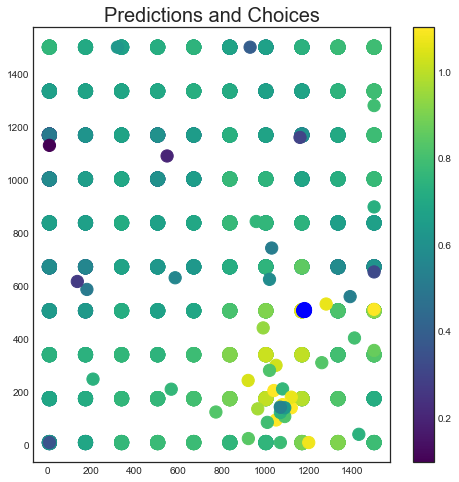

Do you want to continue? (Y/N): N


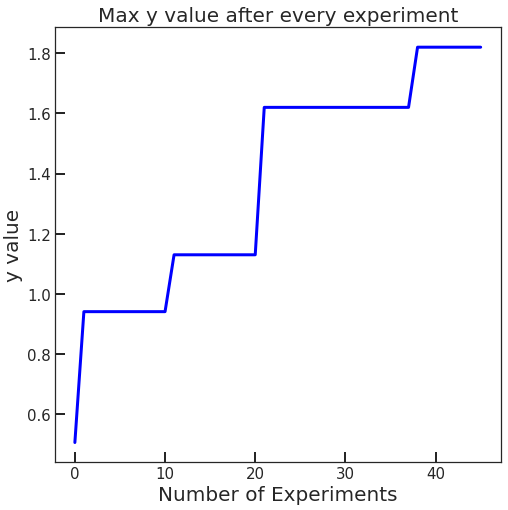

In [165]:
root=Tk()
# Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
label = Label(root, text='Choose file containing experiment data.')
label.pack()
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
mainloop()

data_init = pd.read_csv(filename, sep=',', header=None)
data_init = data_init.values
X_known = data_init[:,:dims].astype(int)
y_known = data_init[:,dims]

if phys_dec == 0:
    pass
elif phys_dec == 1:
    x0 = params
    temp, params = non_lin(fun, x0, X_known, y_known, obj_fun_name) 

exp_num = len(X_known)
curr_batch = int((exp_num-init_points_num)/batch_size)

np.savetxt('Phys_params_%s_batch_%s_%s.csv' % (special, curr_batch, date), pars, delimiter=',')

max_val = np.amax(y_known)
min_val = np.amin(y_known)

# phys_vals = phys_tot[:,2]*(max_val-min_val) + min_val

max_vals = np.array([max_val])
max_locs = np.array(X_known[np.argmax(y_known), :])

for j in range(curr_batch, tot_batches):
    if phys_dec == 0:
        pass
    elif phys_dec == 1:
        X_used, y_used = get_used_data(X_known, y_known, ob_name, tot_points, params)
        # X_known, y_known, ob_name, num, params
        X_used = np.reshape(X_used, (-1,dims))
        y_used = np.reshape(y_used, (-1,1))
    
    par = pars[j]
    
    if phys_dec == 0:
        X_new, tot_preds = run_learner(X_tot, X_known, y_known, batch_size, par,kern, acq, ob_name)
        # X_grid, X_known, y_known, query_number, a, b, d, eps, kern, acq, ob_name
    elif phys_dec == 1:
        X_new, tot_preds = run_learner(X_tot, X_used, y_used, batch_size, par, kern, acq, ob_name)
    
    print(X_new)
    
    np.savetxt('tot_preds_%s_batch_%s_%s.csv' % (special, j, date), tot_preds, delimiter=',')
#     np.savetxt('tot_std_%s_batch_%s_%s.csv' % (special, j, date), std, delimiter=',')
    exp_data = np.concatenate((X_known,np.reshape(y_known, (-1,1))), axis=1)
    exp_data = np.concatenate((exp_data,np.zeros((batch_size,dims+1))))
    exp_data[-batch_size:,:dims] = np.reshape(X_new, (-1,dims))
    np.savetxt('Experiment_data_%s_batch_%s_%s.csv' % (special, j, date), exp_data, delimiter=',')
    
    max_loc = np.argmax(tot_preds)
    print(X_tot[max_loc])
    min_val = np.amin(tot_preds)
    max_val = np.amax(tot_preds)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(8, 8))
        plt.scatter(X_tot[range(10,num**dims, num),0], X_tot[range(10,num**dims, num),1], c=tot_preds[range(10,num**dims, num)], s = 200, cmap = 'viridis', vmin=min_val, vmax=max_val)
#         plt.scatter(X_used[:, 0], X_used[:, 1], c='k', s = 100)
#         plt.scatter(X_tot[X_new_ind.astype(int), 0], X_tot[X_new_ind.astype(int), 1], c='r', s = 100)
        plt.scatter(X_known[:, 0], X_known[:, 1], c=np.ravel(y_known), s = 150, cmap = 'viridis', vmin=min_val, vmax=max_val)
        plt.colorbar()
        plt.scatter(X_new[:, 0], X_new[:, 1], c='b', s=200)
        plt.title('Predictions and Choices', fontsize=20)
        plt.show()
    
    exit_val = 0
    count = 1
    while (exit_val == 0):
        Cont = input('Do you want to continue? (Y/N): ')
        if Cont == 'Y':
            X_known = np.append(X_known, X_new)
            X_known = np.reshape(X_known, (-1,dims))
            
            root=Tk()
            label = Label(root, text='Choose file containing old y values and new y values.')
            label.pack()
            filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
            mainloop()
        
            data = pd.read_csv(filename, sep=',', header=None)
            data = data.values
            y_known = data[:,dims]
            y_known = np.reshape(y_known, (-1,1))
            
            if phys_dec == 0:
                pass
            elif phys_dec == 1:
                x0 = params
                temp, params = non_lin(fun, x0, X_known, y_known, obj_fun_name) 
                np.savetxt('Phys_params_%s_batch_%s_%s.csv' % (special, curr_batch+1, date), pars, delimiter=',')
            count += 1
            exit_val = 1
        elif Cont == 'N':
            break
        else:
            Cont = input('Invalid input!')
    
    
    y_known_max = calc_y_max(y_known)
    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(8, 8))
        plt.plot(np.arange(0,len(y_known_max)), y_known_max, linewidth=3, color = 'blue')
        plt.xlabel('Number of Experiments', fontsize=20)
        plt.ylabel('y value', fontsize=20)
        plt.title('Max y value after every experiment', fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.tick_params(direction='in', length=10,width=2)
        plt.savefig('y_value_%s_batch_%s_%s.png' % (special, j, date), transparent=True)
    
    if Cont == 'N':
        break
        

## Plot results

The following blocks of code were used to plot the results from the BO experiments in various ways. 

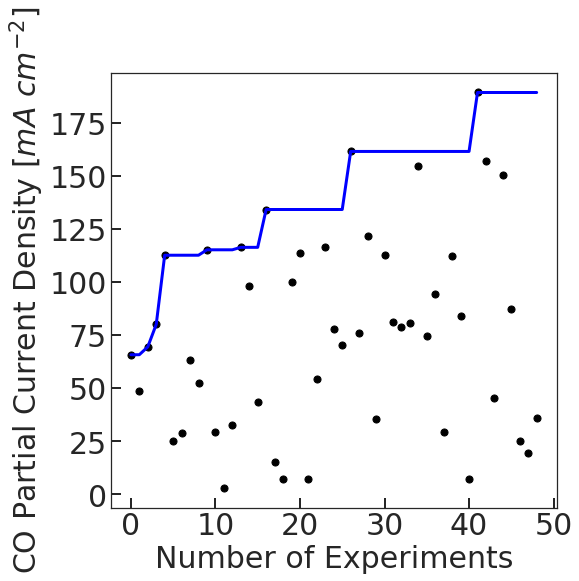

In [15]:
data = pd.read_csv('Experiment_data_CO2_pulse_3D_production_rate_2021-07-13.csv', sep=',', header=None)
# data = pd.read_csv('3D_opt_FE.csv', sep=',', header=None)
data = data.values

y_known = data[:,5]

y_known_max = calc_y_max(y_known)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(0,len(y_known_max)), y_known_max, linewidth=3, color = 'blue')
    plt.scatter(np.arange(0,len(y_known_max)), np.ravel(y_known), c='black', s=50)
    plt.xlabel('Number of Experiments', fontsize=30)
    plt.ylabel('CO Partial Current Density [$mA$ $cm^{-2}$]', fontsize=30)
#     plt.title('3D CO production optimization', fontsize=25)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.tick_params(direction='in', length=10,width=2)
#     plt.savefig('y_value_%s_batch_%s_%s.png' % (special, j, date), transparent=True)

[506.66666667  10.         300.        ]
118.18013643470589


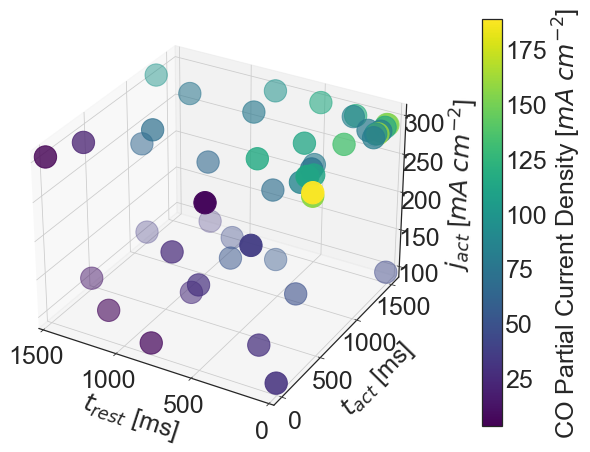

In [19]:
# tot_data = pd.read_csv('tot_preds_CO2_pulse_3D_batch_9_2021-07-13.csv', sep=',', header=None)
# tot_data = tot_data.values


kern = 'rbf'

LB = get_obj_info(ob_name, 'LB')
UB = get_obj_info(ob_name, 'UB')
diff = np.array(UB) - np.array(LB)
min_diff = np.amin(diff)
length_scale = 0.5*diff
# To allow for experimental error inputs, alpha needs to be vector of errors for y_known values (I think?)
alpha = 1e-3
if kern == 'rbf':
    kernel = RBF(length_scale=length_scale, length_scale_bounds=(1e-3,2*min_diff)) \
            + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-3, 1))
elif kern == 'matern':
    kernel = Matern(length_scale=0.2, length_scale_bounds=(1e-2, 2)) \
            + WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1))
elif kern == 'rq':
    kernel = RationalQuadratic(length_scale=0.2, length_scale_bounds=(1e-2, 2)) \
            + WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1))

acq_obj = acquisition()

learner = ActiveLearner(
    estimator=GaussianProcessRegressor(normalize_y=False, kernel=kernel, alpha=alpha, n_restarts_optimizer=100),
    query_strategy=acq_obj.get_acq_fun,
    X_training=data[:,:3], y_training=np.ravel(data[:,5])) 
dims = X_tot.shape[1]
tot_preds, std = learner.predict(X_tot[:,:3], return_std=True) 
tot_preds = np.ravel(tot_preds)
ind_data = np.argmax(tot_preds)
# print(X_tot[ind_data,:])
# print(np.amax(tot_preds))
# resting_curr = X_tot[ind_data,3]
# acting_curr= X_tot[ind_data,2]
# rest_time = X_tot[ind_data,1]
# act_time = X_tot[ind_data,0]

# rest_vals = np.linspace(0,75,40)
# mid_val = curr_vals[9]
# time_vals = np.linspace(10,1500,20)

X_0 = X_tot[X_tot[:,2]==300]
inds_0 = X_tot_num[X_tot[:,2]==300][:,3]
# X_25 = X_tot[X_tot[:,2]==300]
# inds_25 = X_tot_num[X_tot[:,2]==300][:,3]
# X_50 = X_tot[X_tot[:,2]==50]
# inds_50 = X_tot_num[X_tot[:,2]==50][:,3]
# X_75 = X_tot[X_tot[:,2]==75]
# inds_75 = X_tot_num[X_tot[:,2]==75][:,3]
loc = np.argmax(tot_preds[inds_0.astype(int)])
print(X_0[loc,:])

print(np.amax(tot_preds[inds_0.astype(int)]))

# X_slice_1 = X_0[X_0[:,0]==act_time]
# inds_slice_1 = inds_0[X_0[:,0]==act_time]

# X_slice_2 = X_0[X_0[:,1]==rest_time]
# inds_slice_2 = inds_0[X_0[:,1]==rest_time]

# X_slice_3 = X_0[X_0[:,2]==acting_curr]
# inds_slice_3 = inds_0[X_0[:,2]==acting_curr]


# max_0 = np.amax(tot_preds[inds_slice_1.astype(int)])
# max_25 = np.amax(tot_preds[inds_slice_2.astype(int)])
# max_50 = np.amax(tot_preds[inds_slice_3.astype(int)])
# max_val = np.amax([max_0, max_25, max_50])

# min_0 = np.amin(tot_preds[inds_slice_1.astype(int)])
# min_25 = np.amin(tot_preds[inds_slice_2.astype(int)])
# min_50 = np.amin(tot_preds[inds_slice_3.astype(int)])
# min_val = np.amin([min_0, min_25, min_50])

# std_norm = (std-min_val)/(max_val-min_val)

PiYGBig = cm.get_cmap('magma', 512)
newcmp = ListedColormap(PiYGBig(np.linspace(0, 0.7, 256)))

with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax1 = ax.scatter(data[:,1], data[:,0], data[:,2], c=np.ravel(data[:,5]), s = 500, cmap = 'viridis')
    cb = fig.colorbar(ax1, shrink=.75, pad=0.1)
    cb.ax.tick_params(labelsize=25)
    cb.set_label(label='CO Partial Current Density [$mA$ $cm^{-2}$]', size=25)
#     plt.colorbar()
#     plt.scatter(X_used[:, 0], X_used[:, 1], c='k', s = 100)
#     plt.scatter(X_tot[X_new_ind.astype(int), 0], X_tot[X_new_ind.astype(int), 1], c='r', s = 100)
#     ax2 = ax.scatter(data[:, 0], data[:, 1], data[:,2],c=data[:,3], s = 200, cmap = 'winter')
#     fig.colorbar(ax2, shrink=.75, pad=0.15, label='Resting current density [mA/c$m^2$]')
#     plt.colorbar()
#     plt.scatter(X_slice_3[:, 0], X_slice_3[:, 1], c=np.ravel(tot_preds[inds_slice_3.astype(int)]), s=300, cmap = 'plasma', vmin=min_val, vmax=max_val)
#     plt.scatter(X_tot[:, 0], X_tot[:, 1], c=np.ravel(tot_preds), s=300, cmap = 'plasma')
#     cb = plt.colorbar()
#     cb.ax.tick_params(labelsize=30)
#     ax.set_xlim(1500,0)
    plt.xticks(ticks=(0, 500, 1000, 1500), fontsize=25)
    plt.yticks(ticks=(1500, 1000, 500, 0), fontsize=25)
    ax.set_zticks(ticks=(100, 150, 200, 250, 300))
#     plt.xticks(fontsize=30, rotation=45)
#     plt.yticks(fontsize=30)
    for tick in ax.zaxis.get_major_ticks():
        tick.label.set_fontsize(25)  

    ax.set_xlabel('$t_{rest}$ [ms]', fontsize=25, labelpad=15)
    ax.set_xlim(1500, 0)
    ax.set_ylabel('$t_{act}$ [ms]', fontsize=25, labelpad=15)
#     plt.xlabel('$t_{act}$ [ms]', fontsize=30)
#     plt.ylabel('$t_{rest}$ [ms]', fontsize=30)
#     plt.ylabel('$j_{act}$ [$mA$ $cm^{-2}$]', fontsize=30)
    plt.tick_params(direction='in', length=10,width=2)
#     plt.xlim((-5,1505))
#     plt.ylim((-5,1505))
#     plt.ylabel('Resting time [ms]', fontsize=20)
    ax.set_zlabel('$j_{act}$ [$mA$ $cm^{-2}$]', fontsize=25, labelpad=15)
#     plt.title('4D Experimental Points', fontsize=25)
#     plt.title('(A) CO Faradaic Efficiency at 100 $mA$ $cm^{-2}$', fontsize=25)
    plt.show()

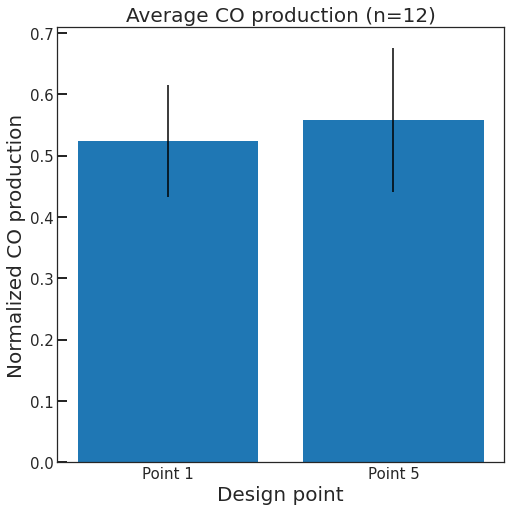

In [243]:
points = pd.read_csv('4D_opt_points_1_5_20210718-20.csv', sep=',', header=None)
points = points.values

points_1 = np.mean(points[:,0])
points_1_std = np.std(points[:,0])

points_5 = np.mean(points[:,1])
points_5_std = np.std(points[:,1])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 8))
    plt.bar([0,1], [points_1,points_5], width=.8, yerr=[points_1_std,points_5_std], tick_label=['Point 1', 'Point 5'])
    plt.xlabel('Design point', fontsize=20)
    plt.ylabel('Normalized CO production', fontsize=20)
    plt.title('Average CO production (n=12)', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tick_params(direction='in', length=10,width=2)
#     plt.savefig('y_value_%s_batch_%s_%s.png' % (special, j, date), transparent=True)